# Importing Libraries

In [1]:
# data manipulation
import pandas as pd

# Database I/O
import sqlite3

# for some data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# to get data from the internet
import requests

# for unzipping files
import gzip
import shutil
from io import BytesIO

Let's create a function to get data from our database

In [23]:
def get_sqlite_connection():
    database_path = 'data/database/citibike_data.db'
    return sqlite3.connect(database_path)

def sqlite_select_query(sql_query):
    with get_sqlite_connection() as connection:
        return pd.read_sql_query(sql_query, connection)

def table_exists(table_name):
    with get_sqlite_connection() as connection:
        cursor = connection.cursor()
        cursor.execute(
            f"Select name from sqlite_master where type ='table' and name = '{table_name}'"
        )
        return cursor.fetchone() is not None

In [3]:
# Let's get a dataset of daily rides
daily_rides_df = sqlite_select_query(
    "select strftime('%Y-%m-%d', trip_start_at) as trip_start_date, sum(ride_count) as daily_rides FROM ride_counts_by_hour group by 1"
)

daily_rides_df['trip_start_date'] = pd.to_datetime(daily_rides_df['trip_start_date'])

daily_rides_df.head()

,trip_start_date,daily_rides
0,2013-06-01,8722
1,2013-06-02,15971
2,2013-06-03,7598
3,2013-06-04,15782
4,2013-06-05,15690


In [4]:
# Just in case, let's create a week field

daily_rides_df['week_ending_monday'] = daily_rides_df['trip_start_date'] + pd.to_timedelta((6 - daily_rides_df['trip_start_date'].dt.dayofweek) % 7 + 1, unit='D')

daily_rides_df

,trip_start_date,daily_rides,week_ending_monday
0,2013-06-01,8722,2013-06-03
1,2013-06-02,15971,2013-06-03
2,2013-06-03,7598,2013-06-10
3,2013-06-04,15782,2013-06-10
4,2013-06-05,15690,2013-06-10
...,...,...,...
3821,2023-11-26,46249,2023-11-27
3822,2023-11-27,89180,2023-12-04
3823,2023-11-28,82936,2023-12-04
3824,2023-11-29,83511,2023-12-04


Let's see the weekly rides plotted

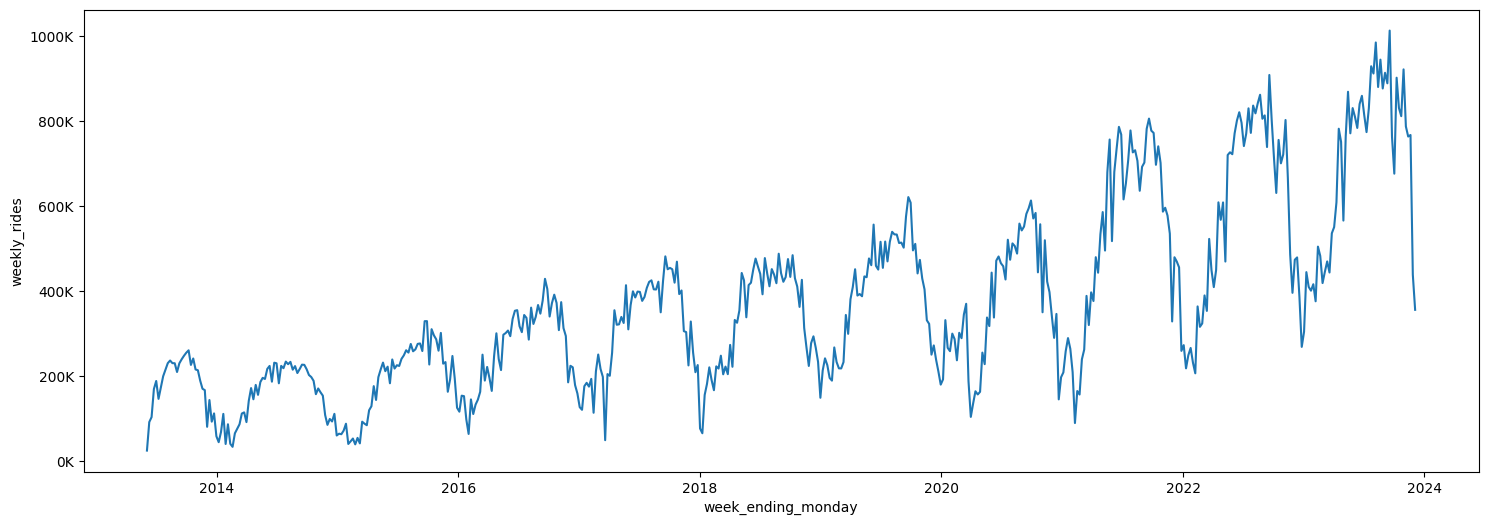

In [5]:
weekly_rides = daily_rides_df[['week_ending_monday','daily_rides']].groupby('week_ending_monday').sum().reset_index().rename(columns={'daily_rides':'weekly_rides'})
# Make the figure larger
plt.figure(figsize=(18, 6))

# Create a line plot
sns.lineplot(
    x = 'week_ending_monday'
    , y = 'weekly_rides'
    , data = weekly_rides
)

# This changes the y Axis so we get it in thousands
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}K'.format(x / 1000)))

plt.show()


In [6]:
weekly_rides.describe()

,week_ending_monday,weekly_rides
count,549,5.490000e+02
mean,2018-09-03 00:00:00,3.711395e+05
min,2013-06-03 00:00:00,2.469300e+04
25%,2016-01-18 00:00:00,2.140520e+05
50%,2018-09-03 00:00:00,3.247840e+05
75%,2021-04-19 00:00:00,4.766240e+05
max,2023-12-04 00:00:00,1.012506e+06
std,NaN,2.179567e+05


# Let's see what's correlated with ridership.
## First off, weather.
We're going to use the [NCEI NOAA](https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station) data anchored on the central park station.

In [75]:
weather_file = 'USW00094728.csv.gz'
weather_url = f"https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_station/{weather_file}"
response = requests.get(weather_url)

with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as gz_file:
    weather_data_df = pd.read_csv(
        gz_file
        , names = [
            'station_id'
            , 'date'
            , 'element'
            , 'data_value'
            , 'measurement_flag'
            , 'quality_flag'
            , 'source_flag'
            , 'observation_time'
        ]
        , parse_dates=['date']
        )

weather_data_df.tail()

C:\Users\Richie\AppData\Local\Temp\ipykernel_25968\3876568106.py:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data_df = pd.read_csv(


,station_id,date,element,data_value,measurement_flag,quality_flag,source_flag,observation_time
451398,USW00094728,2023-12-11,WT03,1,NaN,NaN,W,NaN
451399,USW00094728,2023-12-02,WT08,1,NaN,NaN,W,NaN
451400,USW00094728,2023-12-03,WT08,1,NaN,NaN,W,NaN
451401,USW00094728,2023-12-04,WT08,1,NaN,NaN,W,NaN
451402,USW00094728,2023-12-09,WT08,1,NaN,NaN,W,NaN


Using the [documentation here](https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt) I was able to create a mapping between the element field and find definitions for them. Using that i'll create a table in our database.

In [76]:
# Open a database connection and write the csv to the database
with get_sqlite_connection() as connection:
    pd.read_csv(
        'data/lookup_files/ncei_element_lookup.csv'
    ).merge(
        weather_data_df
        , on = ['element']
        , how = 'left'
    ).to_sql(
        'ncei_element_lookup'
        , connection
        , index=False
        , if_exists='replace'
    )
    weather_data_df = pd.read_sql_query('select * from ncei_element_lookup', connection, parse_dates=['date'])

In [9]:
# Let's see how weekly ridership correlates with the available data. First let's get a median temparature by week
weather_data_df['week_ending_monday'] = weather_data_df['date'] + pd.to_timedelta((6 - weather_data_df['date'].dt.dayofweek) % 7 +1, unit='D')

weather_data_df[weather_data_df['element'] == 'TAVG']['date'].max()

Timestamp('2005-07-31 00:00:00')

In [10]:
# It looks like the max date with TAVG is in 2005. Because of this we'll need to calculate TAVG ourselves
avg_temp_df = weather_data_df[weather_data_df['element'].isin(['TMIN','TMAX'])][['date','week_ending_monday','data_value']].groupby(['date','week_ending_monday']).mean().reset_index()

median_temp_df = avg_temp_df[['week_ending_monday', 'data_value']].groupby('week_ending_monday').median().reset_index().rename(columns = {'data_value' : 'median_temperature'})

# Let's convert celcius (to tenths place) into kelvin (adding 2731.5)
median_temp_df['kelvin_temp'] = median_temp_df['median_temperature'] + 2731.5

median_temp_df.head()

,week_ending_monday,median_temperature,kelvin_temp
0,1869-01-04,-44.5,2687.0
1,1869-01-11,44.5,2776.0
2,1869-01-18,5.5,2737.0
3,1869-01-25,-8.5,2723.0
4,1869-02-01,19.5,2751.0


In [11]:
# Join the weekly_rides_df to the median_temp_df

rides_temperature_df = weekly_rides.merge(
    median_temp_df
    , on = 'week_ending_monday'
)

rides_temperature_df.tail()

,week_ending_monday,weekly_rides,median_temperature,kelvin_temp
544,2023-11-06,787051,92.0,2823.5
545,2023-11-13,763339,94.5,2826.0
546,2023-11-20,766911,86.5,2818.0
547,2023-11-27,438296,56.0,2787.5
548,2023-12-04,355743,77.5,2809.0


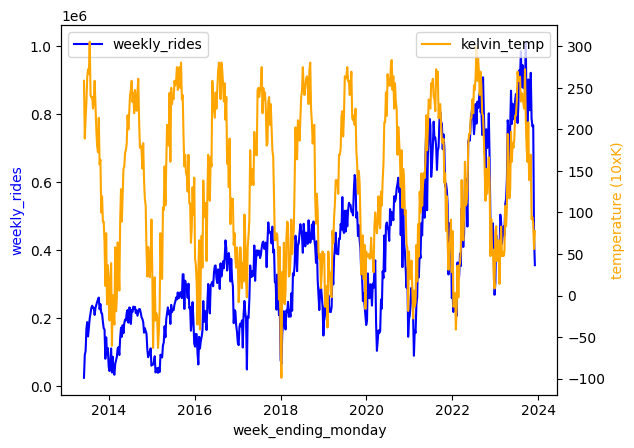

In [70]:
# plot both on a graph with a dual axis

# Create the first plot
rides_line = sns.lineplot(
    x = 'week_ending_monday'
    , y = 'weekly_rides'
    , data = rides_temperature_df
    , label = 'weekly_rides'
    , color = 'blue'
)

# Create the second plot on the secondary y-axis
shared_axis = rides_line.twinx()
temperature_line = sns.lineplot(
    x = 'week_ending_monday'
    , y = 'median_temperature'
    , data = rides_temperature_df
    , label = 'kelvin_temp'
    , ax = shared_axis
    , color = 'orange'
)

# Set labels and legend
rides_line.set_ylabel('weekly_rides', color='blue')
temperature_line.set_ylabel('temperature (10xK)', color='orange')
rides_line.set_xlabel('week_ending_monday')

# Show the legend
rides_line.legend(loc='upper left')
temperature_line.legend(loc='upper right')

# Show the plot
plt.show()


There is obviously some correlation between the median temperature and the number of riders. Although it's not very straightforward. Seems pretty obvious right now that we need a way to control for growth.

In [13]:
# Just trying with a pearson correlation for tradition's sake

temp_ridership_pearson_corr = rides_temperature_df['kelvin_temp'].corr(rides_temperature_df['weekly_rides'])

print(f'Pearson Correlation Coefficient: {temp_ridership_pearson_corr}')

Pearson Correlation Coefficient: 0.5213617998664526


That 0.521 isn't bad but we know that there's more to it than temperature. Maybe we can get a count of stations per day?
It seems to make sense that adding more stations would increase ridership

In [36]:
tables_query = """
    select 
        name
    from sqlite_master
    where 
        type='table' 
        and substr(name, 16, 2) = '20'
"""

stations_by_week_table = 'unique_stations_by_week'

if table_exists(stations_by_week_table):
    stations_df = sqlite_select_query(
        f'select * from {stations_by_week_table}'
    )

    stations_df['week_ending_monday'] = pd.to_datetime(stations_df['week_ending_monday'])

else:

    weekly_station_count_list = []

    for each_table in sqlite_select_query(tables_query)['name'].tolist():
        print(f'Getting data from {each_table}...')
        get_daily_station_count_query = f"select strftime('%Y-%m-%d', started_at) as trip_start_date, count(distinct start_station_name) as unique_station_count from {each_table} group by 1"

        tdf = sqlite_select_query(get_daily_station_count_query)
        tdf['trip_start_date'] = pd.to_datetime(tdf['trip_start_date'])

        tdf['week_ending_monday'] = tdf['trip_start_date'] + pd.to_timedelta((6 - tdf['trip_start_date'].dt.dayofweek) % 7 +1, unit='D')

        tdf = tdf[['week_ending_monday', 'unique_station_count']].groupby('week_ending_monday').max().reset_index()

        weekly_station_count_list.append(
            tdf
        )

    del tdf

    stations_df = pd.concat(weekly_station_count_list)

    with get_sqlite_connection() as connection:
        stations_df.to_sql(
            stations_by_week_table
            , connection
            , if_exists='replace'
            , index=False
        )
        print(f'Created table {stations_by_week_table}')


stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   week_ending_monday    558 non-null    datetime64[ns]
 1   unique_station_count  558 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.8 KB


Doing some data validaiton, according to Wikipedia on 2023-12-20:

>It officially opened in May 2013 with 332 stations and 6,000 bikes. By October 2017 annual expansions brought the totals to 706 stations and 12,000 bikes.

Also:

> Number of stations	1,915 (September 2023)

In [67]:
print(f"2023-09-11 Station Count =  {stations_df.loc[stations_df['week_ending_monday'] == '2023-09-11', 'unique_station_count'].to_list()[0]}")

print(f"2013-06-03 Station Count =  {stations_df.loc[stations_df['week_ending_monday'] == '2013-06-03', 'unique_station_count'].to_list()[0]}")

print(f"2017-10-23 Station Count =  {stations_df.loc[stations_df['week_ending_monday'] == '2017-10-23', 'unique_station_count'].to_list()[0]}")


2023-09-11 Station Count =  1893
2013-06-03 Station Count =  332
2017-10-23 Station Count =  726


Data check looks good, lets merge it with the dataset and correlate the two.

In [68]:
working_data_df = rides_temperature_df.merge(
    stations_df
    , on = 'week_ending_monday'
)

working_data_df.head()

,week_ending_monday,weekly_rides,median_temperature,kelvin_temp,unique_station_count
0,2013-06-03,24693,258.5,2990.0,332
1,2013-06-10,91757,189.0,2920.5,331
2,2013-06-17,103390,213.5,2945.0,331
3,2013-06-24,169471,233.5,2965.0,333
4,2013-07-01,188391,264.0,2995.5,334


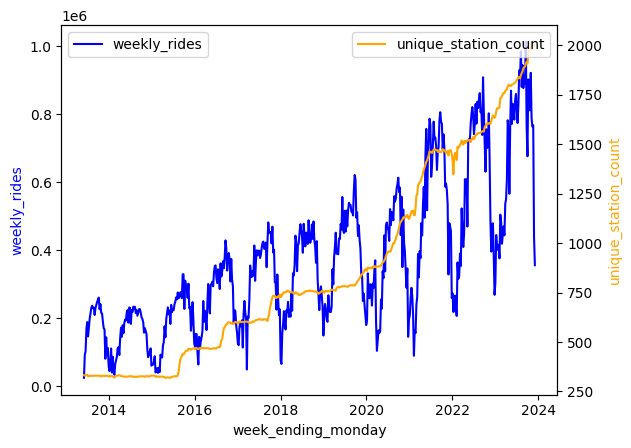

In [72]:
# plot both on a graph with a dual axis

# Create the first plot
rides_line = sns.lineplot(
    x = 'week_ending_monday'
    , y = 'weekly_rides'
    , data = working_data_df
    , label = 'weekly_rides'
    , color = 'blue'
)

# Create the second plot on the secondary y-axis
shared_axis = rides_line.twinx()
temperature_line = sns.lineplot(
    x = 'week_ending_monday'
    , y = 'unique_station_count'
    , data = working_data_df
    , label = 'unique_station_count'
    , ax = shared_axis
    , color = 'orange'
)

# Set labels and legend
rides_line.set_ylabel('weekly_rides', color='blue')
temperature_line.set_ylabel('unique_station_count', color='orange')
rides_line.set_xlabel('week_ending_monday')

# Show the legend
rides_line.legend(loc='upper left')
temperature_line.legend(loc='upper right')

# Show the plot
plt.show()


Love to see that the footprint greatly increased post-pandemic. It's also interesting that there seems to be a YoY jump at the time that many more stations were introduced (usually during the summer). The largest step in ridership seems to be from 2021 to 2022, where the largest amount of stations were added.

In [74]:
# Get the correlation between weekly rides and the number of stations

stations_ridership_pearson_corr = working_data_df['unique_station_count'].corr(working_data_df['weekly_rides'])

print(f'Pearson Correlation Coefficient: {stations_ridership_pearson_corr}')

Pearson Correlation Coefficient: 0.7852386840562638


A score of .785 isn't bad. So clearly and obviously there's a correlation between the number of stations and riders.